# 📊 Feature Extraction pour ML

Ce notebook extrait les features complètes d'un patient :
- **Embeddings symptômes** (768 dim) via CamemBERT-bio
- **Constantes vitales** (6 dim) : FC, FR, SpO2, TA, Température
- **Info patient** (2 dim) : Âge, Sexe

**Total : 776 features** pour le modèle ML

## 1️⃣ Imports

In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import pandas as pd

print("✅ Imports OK")

c:\Users\HP\Desktop\Master2\llm\Triage_urgence\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Imports OK


## 2️⃣ Charger CamemBERT-bio

In [2]:
print("🔧 Chargement CamemBERT-bio...")

model_name = "almanach/camembert-bio-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

print("✅ Modèle chargé !")

🔧 Chargement CamemBERT-bio...


Loading weights: 100%|██████████| 197/197 [00:00<00:00, 993.93it/s, Materializing param=encoder.layer.11.output.dense.weight]              
CamembertModel LOAD REPORT from: almanach/camembert-bio-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
pooler.dense.weight             | MISSING    | 
pooler.dense.bias               | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


✅ Modèle chargé !


## 3️⃣ Fonction : Encoder symptômes

In [9]:
def encode_symptoms(symptoms: list) -> np.ndarray:
    """
    Encode symptômes en embeddings.
    
    Args:
        symptoms: Liste de symptômes
    
    Returns:
        np.ndarray: Embeddings (768,)
    """
    if not symptoms:
        return np.zeros(768)
    
    text = ", ".join(symptoms)
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return embeddings[0]

# Test
test_emb = encode_symptoms(["fièvre", "toux"])
print(f"✅ Fonction testée : {test_emb.shape}")

✅ Fonction testée : (768,)


## 4️⃣ Fonction : Extraire toutes les features

In [10]:
def extract_features(patient_data: dict) -> np.ndarray:
    """
    Extrait features complètes d'un patient.
    
    Args:
        patient_data: Dict avec symptomes, age, sexe, fc, spo2, etc.
    
    Returns:
        np.ndarray: Feature vector (776,)
    """
    features = []
    
    # 1. Embeddings symptômes (768 dim)
    symptoms = patient_data.get('symptomes', [])
    symptom_emb = encode_symptoms(symptoms)
    features.extend(symptom_emb)
    
    # 2. Constantes vitales normalisées (6 dim)
    fc = patient_data.get('fc', 80)
    fr = patient_data.get('fr', 16)
    spo2 = patient_data.get('spo2', 98)
    ta_sys = patient_data.get('ta_systolique', 120)
    ta_dia = patient_data.get('ta_diastolique', 80)
    temp = patient_data.get('temperature', 37.0)
    
    # Normalisation
    fc_norm = (fc - 70) / 30
    fr_norm = (fr - 16) / 5
    spo2_norm = (spo2 - 95) / 5
    ta_sys_norm = (ta_sys - 120) / 20
    ta_dia_norm = (ta_dia - 80) / 10
    temp_norm = (temp - 37) / 2
    
    features.extend([fc_norm, fr_norm, spo2_norm, ta_sys_norm, ta_dia_norm, temp_norm])
    
    # 3. Patient (2 dim)
    age = patient_data.get('age', 50)
    sexe = patient_data.get('sexe', 'M')
    
    age_norm = (age - 50) / 25
    sexe_encoded = 1 if sexe == 'M' else 0
    
    features.extend([age_norm, sexe_encoded])
    
    return np.array(features)

print("✅ Fonction extract_features créée")

✅ Fonction extract_features créée


## 5️⃣ Test sur patients d'exemple

In [11]:
# Patients de test (4 niveaux de gravité)
patients = [
    # ROUGE - Infarctus
    {
        "symptomes": ["douleur thoracique intense", "essoufflement", "sueurs froides"],
        "age": 65,
        "sexe": "M",
        "fc": 120,
        "fr": 24,
        "spo2": 88,
        "ta_systolique": 90,
        "ta_diastolique": 60,
        "temperature": 37.0,
        "gravite": "ROUGE"
    },
    # JAUNE - Fracture
    {
        "symptomes": ["douleur au bras", "gonflement"],
        "age": 35,
        "sexe": "F",
        "fc": 85,
        "fr": 18,
        "spo2": 98,
        "ta_systolique": 120,
        "ta_diastolique": 80,
        "temperature": 36.8,
        "gravite": "JAUNE"
    },
    # VERT - Gastro
    {
        "symptomes": ["nausées", "diarrhée"],
        "age": 28,
        "sexe": "F",
        "fc": 75,
        "fr": 16,
        "spo2": 99,
        "ta_systolique": 115,
        "ta_diastolique": 75,
        "temperature": 37.8,
        "gravite": "VERT"
    },
    # GRIS - Certificat
    {
        "symptomes": ["besoin certificat médical"],
        "age": 22,
        "sexe": "M",
        "fc": 70,
        "fr": 14,
        "spo2": 99,
        "ta_systolique": 120,
        "ta_diastolique": 80,
        "temperature": 36.7,
        "gravite": "GRIS"
    }
]

print(f"✅ {len(patients)} patients de test créés")

✅ 4 patients de test créés


In [12]:
# Extraire features pour chaque patient
print("🔍 Extraction features...\n")

features_list = []
labels = []

for i, patient in enumerate(patients):
    features = extract_features(patient)
    features_list.append(features)
    labels.append(patient['gravite'])
    
    print(f"Patient {i+1} - {patient['gravite']}")
    print(f"   Symptômes : {patient['symptomes']}")
    print(f"   Features shape : {features.shape}")
    print(f"   FC norm : {features[768]:.2f}")
    print(f"   SpO2 norm : {features[770]:.2f}")
    print()

# Convertir en array
X = np.array(features_list)
y = np.array(labels)

print(f"✅ Features extraites !")
print(f"   X shape : {X.shape}")
print(f"   y shape : {y.shape}")

🔍 Extraction features...

Patient 1 - ROUGE
   Symptômes : ['douleur thoracique intense', 'essoufflement', 'sueurs froides']
   Features shape : (776,)
   FC norm : 1.67
   SpO2 norm : -1.40

Patient 2 - JAUNE
   Symptômes : ['douleur au bras', 'gonflement']
   Features shape : (776,)
   FC norm : 0.50
   SpO2 norm : 0.60

Patient 3 - VERT
   Symptômes : ['nausées', 'diarrhée']
   Features shape : (776,)
   FC norm : 0.17
   SpO2 norm : 0.80

Patient 4 - GRIS
   Symptômes : ['besoin certificat médical']
   Features shape : (776,)
   FC norm : 0.00
   SpO2 norm : 0.80

✅ Features extraites !
   X shape : (4, 776)
   y shape : (4,)


## 6️⃣ Visualisation des features

  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 8.1/8.1 MB 51.2 MB/s  0:00:00
Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 59.3 MB/s  0:00:00
Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl (73 kB)

   ---------------------------------------- 0/6 [pyparsing]
   ---------------------------------------- 0/6 [pyparsing]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- 

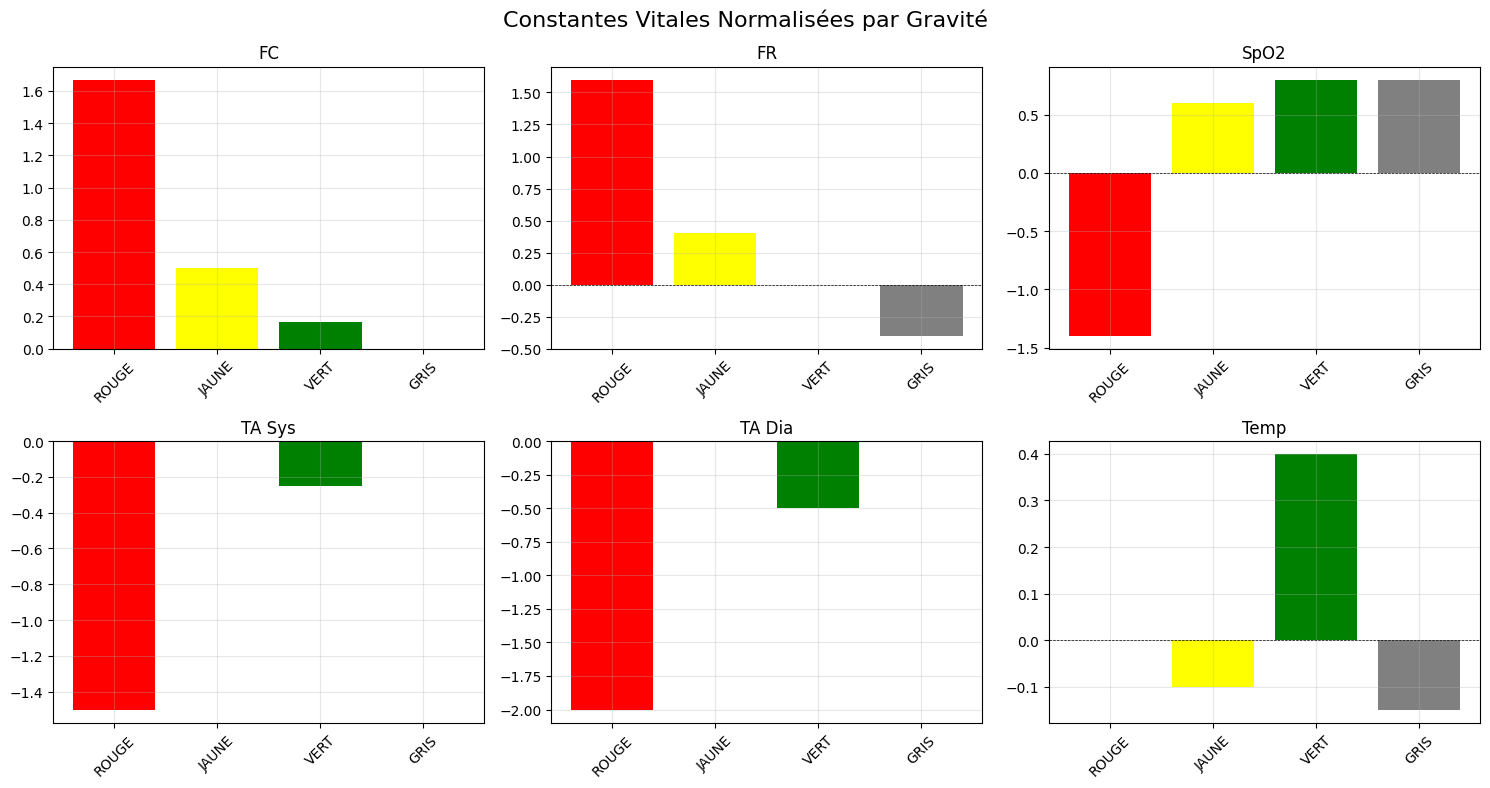

✅ Visualisation OK


In [14]:
!pip install matplotlib
import matplotlib.pyplot as plt

# Visualiser les constantes normalisées
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Constantes Vitales Normalisées par Gravité', fontsize=16)

constantes_names = ['FC', 'FR', 'SpO2', 'TA Sys', 'TA Dia', 'Temp']
constantes_idx = [768, 769, 770, 771, 772, 773]

for idx, (ax, name, feat_idx) in enumerate(zip(axes.flat, constantes_names, constantes_idx)):
    values = X[:, feat_idx]
    colors = ['red', 'yellow', 'green', 'gray']
    
    ax.bar(range(len(values)), values, color=colors)
    ax.set_title(name)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualisation OK")

## 7️⃣ Résumé des features

In [15]:
summary = pd.DataFrame({
    'Patient': [f"P{i+1}" for i in range(len(patients))],
    'Gravité': labels,
    'FC_norm': X[:, 768],
    'SpO2_norm': X[:, 770],
    'Temp_norm': X[:, 773],
    'Age_norm': X[:, 774],
    'Sexe': X[:, 775]
})

print("\n📊 RÉSUMÉ DES FEATURES")
print("="*80)
print(summary.to_string(index=False))
print("="*80)

print("\n💡 Observations :")
print("   - ROUGE : SpO2 bas (-1.4), FC élevé")
print("   - JAUNE : Valeurs modérées")
print("   - VERT/GRIS : Valeurs normales")


📊 RÉSUMÉ DES FEATURES
Patient Gravité  FC_norm  SpO2_norm  Temp_norm  Age_norm  Sexe
     P1   ROUGE 1.666667       -1.4       0.00      0.60   1.0
     P2   JAUNE 0.500000        0.6      -0.10     -0.60   0.0
     P3    VERT 0.166667        0.8       0.40     -0.88   0.0
     P4    GRIS 0.000000        0.8      -0.15     -1.12   1.0

💡 Observations :
   - ROUGE : SpO2 bas (-1.4), FC élevé
   - JAUNE : Valeurs modérées
   - VERT/GRIS : Valeurs normales


## ✅ Conclusion

**Features extraites avec succès !**

**Structure :**
- 768 dim : Embeddings symptômes (CamemBERT-bio)
- 6 dim : Constantes vitales normalisées
- 2 dim : Âge + Sexe
- **Total : 776 dimensions**

**Prochaine étape :** Générer un dataset annoté pour entraîner le modèle ML.

→ Voir notebook `03_generate_dataset.ipynb`